In [23]:
import json, math

import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\remib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\remib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
with open('data/processed/deputees_17.json','r',encoding='utf-8') as f:
    data = json.load(f)

with open('data/processed/communautes_17.json','r') as f:
    communities = json.load(f)
    

In [25]:
def plot_community_wordclouds(tf_idf_by_communities):
    """
    Plot the wordcloud
    """

    # --- 1. Configure the subplot grid ---
    num_communities = len(tf_idf_by_communities)
    # Determine the grid layout (aim for max 3 columns)
    cols = min(num_communities, 3)
    # Calculate the number of rows needed
    rows = (num_communities + cols - 1) // cols
    # Create the figure with a proportional size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 6))
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten() if num_communities > 1 else [axes]
    # --- 3. Generate one word cloud ---

    for i, (community_name, frequency_dict) in enumerate(tf_idf_by_communities.items()):
        # Determine which axis to draw on
        ax = axes_flat[i]
        # --- 3a. Generate the word cloud ---
        try:
            wc = WordCloud(width=800,
                           height=600,
                           background_color='white',
                           colormap='viridis', # Change the colormap
                           max_words=100       # Limit the number of words
                           ).generate_from_frequencies(frequency_dict)

            # --- 3b. Display on the subplot ---
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(f"Community: {community_name}")
            ax.axis('off')

        except Exception as e:
            print(f"Error generating word cloud for {community_name}: {e}")
            ax.set_title(f"WordCloud Error: {community_name}")
            ax.axis('off')

    # --- 4. Clean up unused axes ---
    # Hide subplots that were not used
    for j in range(num_communities, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)

    # Display the final plot
    print("Displaying plot...")
    plt.show()

# Basic TF-IDF made by communities

In [26]:
# --- STEP 1: Pre-processing speeches for each deputy ---
# We create a set of unique words for each deputy to easily check for word presence for Basic and advanced processing
print('Preprocessing speeches')
stop_words = set(stopwords.words('french'))
community_counters = []
deputy_words = {}
all_words = set()
for i,community in enumerate(communities):
    print(f"Community {i} : {len(community)} deputees")
    community_counter = Counter()
    for j,deputee_id in enumerate(community):
        print(f"  Processing deputee {j+1}/{len(community)}: {deputee_id}",end='\r')
        deputy_words[deputee_id] = Counter()
        for phrase in data[deputee_id]['speeches']:
            token = word_tokenize(phrase, language='french')
            # token = word_tokenize(" ".join([ele for ele in phrase.split() if not ele[0].isupper()]).lower(), language='french')
            processed_words = [word.lower() for word in token if word.isalpha() and word.lower() not in stop_words]
            community_counter.update(processed_words)
            all_words.update(processed_words)
            deputy_words[deputee_id].update(processed_words)
    community_counters.append(community_counter)
    print('\n')   

Preprocessing speeches
Community 0 : 235 deputees
  Processing deputee 235/235: PA721984

Community 1 : 201 deputees
  Processing deputee 201/201: PA795808

Community 2 : 167 deputees
  Processing deputee 167/167: PA720614



In [27]:
doc_tfs = {}
doc_freq = {}
all_words = set()
num_communities = len(community_counters)



print("\n--- STEP 2.1: Calculating Term Frequency (TF) ---")
def TF(count, max_count):
    if max_count == 0:
        return 0
    K =0.25
    return K + (1-K) * count / max_count

for comm_name, counter in enumerate(community_counters):
    max_words_in_doc = max(counter.values())

    augmented_tfs_for_doc = {}
    if max_words_in_doc > 0:
        for word, count in counter.items(): #double normalization 0.5	
            augmented_tfs_for_doc[word] = TF(count,max_words_in_doc)
    doc_tfs[comm_name] = augmented_tfs_for_doc


    # Update document frequency (DF)
    for word in counter.keys():
        if word not in doc_freq:
            doc_freq[word] = 1
        else:
            doc_freq[word] += 1
        all_words.add(word)

print("\n--- STEP 2.2: Calculating Inverse Document Frequency (IDF) ---")
def IDF(word,N):
    df = doc_freq.get(word, 0)
    return math.log( N / (df + 1))

idf_scores = {}
N = num_communities
for word in all_words:
    idf_scores[word] = IDF(word,N)

# Create the master list of all sorted words (for consistent output order)
sorted_words = sorted(list(all_words))

print("\n--- STEP 3: Calculating TF-IDF ---")
tf_idf_by_communities = {}
for i in range(num_communities):
    print(f"Processing community {i}/{num_communities}")
    current_doc_tf = doc_tfs.get(i, {})
    tf_idf_by_communities[i] = {}
    for word in sorted_words:
        # Get normalized TF (0 if the word is not in this doc)
        tf = current_doc_tf.get(word, 0.0)
        # Get pre-calculated IDF
        idf = idf_scores.get(word, 0.0)

        # Final TF-IDF calculation
        tf_idf = tf * idf

        # Write the word and the TF-IDF score
        tf_idf_by_communities[i][word] = tf_idf



--- STEP 2.1: Calculating Term Frequency (TF) ---

--- STEP 2.2: Calculating Inverse Document Frequency (IDF) ---

--- STEP 3: Calculating TF-IDF ---
Processing community 0/3
Processing community 1/3
Processing community 2/3


Displaying plot...


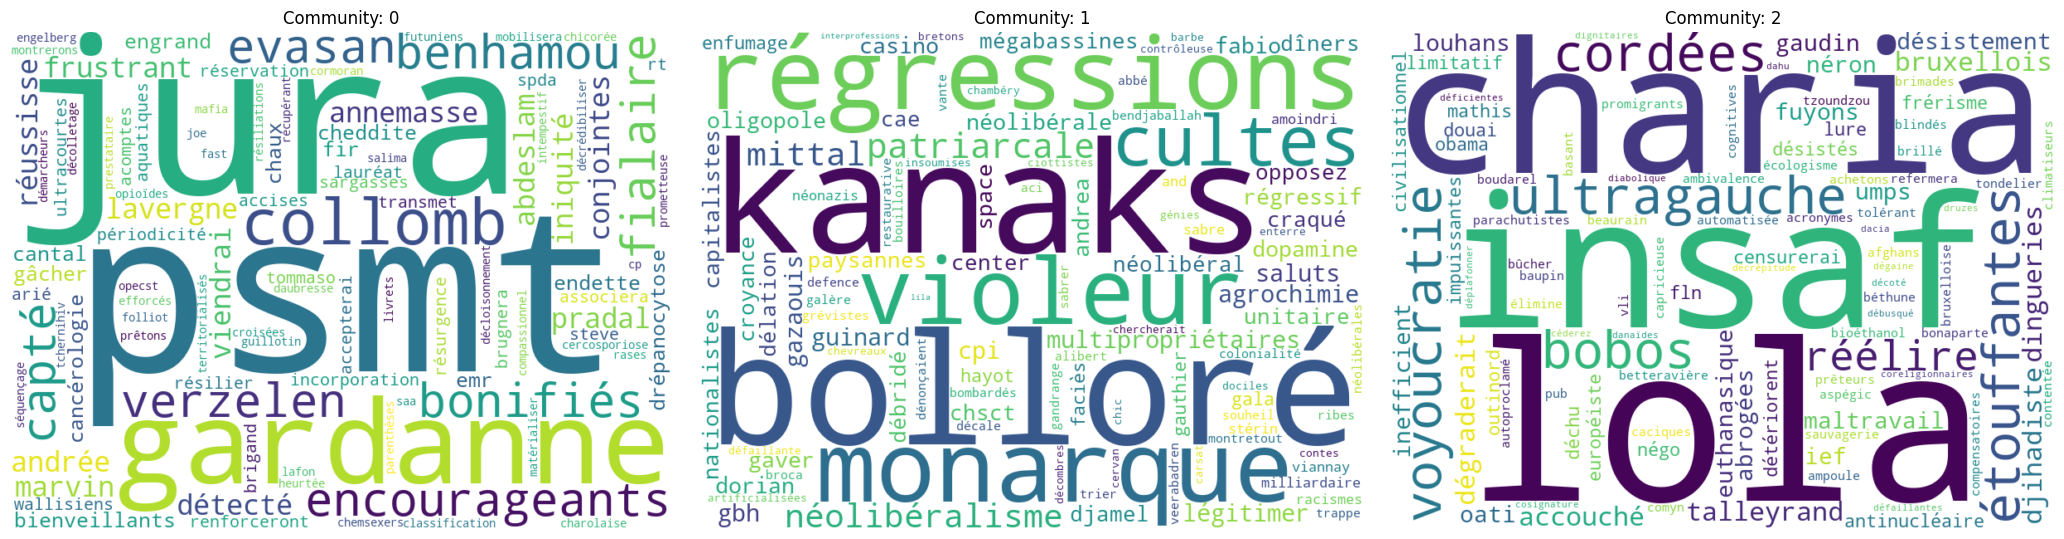

In [28]:
plot_community_wordclouds(tf_idf_by_communities)


# TF-DF to retrieve general words in a community

In [29]:
community_counters = {}
for i,community in enumerate(communities):
    print(f"Community {i} : {len(community)} deputees")
    community_counter = Counter()
    for j,deputee_id in enumerate(community):
        community_counter.update(deputy_words[deputee_id])
    community_counters[i] = community_counter


# --- STEP 2: Calculate Term Frequency ---
def TF(count, max_count):
    if max_count == 0:
        return 0
    K =0.25
    U = 0.5
    return K + (1-K) * (count / max_count) ** U

print('Calculating Term Frequency')
for comm_name, counter in community_counters.items():
    max_freq_in_comm = max(counter.values())

    augmented_tfs_for_com = {}
    if max_freq_in_comm > 0:
        for word, count in counter.items(): #double normalization 0.5	
            augmented_tfs_for_com[word] = TF(count,max_freq_in_comm)
    doc_tfs[comm_name] = augmented_tfs_for_com
        
# --- STEP 3: Calculate Document Frequency (DF) within each community ---
# Here, DF is the number of deputies in a community who use a specific word.
def DF(word,N):
    word_appearance = df_number_sharing_inside_communities[i].get(word, 0)
    K=0.985
    return word_appearance / N
    # return math.log( K*N / (N-word_appearance + 1))/math.log(N)

print('Calculate DF inside communities')
df_inside_communities = {}
df_number_sharing_inside_communities = {}
for i, community in enumerate(communities):
    df_inside = Counter()
    print(f"Processing Community {i} for DF calculation...")
    for deputee_id in community:
            df_inside.update(deputy_words[deputee_id].keys())
    df_number_sharing_inside_communities[i] = df_inside

for i,df_inside in df_number_sharing_inside_communities.items():
    number_deputies = len(communities[i])
    df_inside = df_inside.copy()
    for word in df_inside.keys():
        df_inside[word] = DF(word,number_deputies)
    df_inside_communities[i] = df_inside


# --- STEP 4: Calculate Inverse Document Frequency (IDF) across communities ---
# This measures how unique a word is across all communities.
def IDF(word,N):
    word_appearance = all_words_frequency.get(word, num_communities)
    return math.log( N / (word_appearance + 1)) / math.log(N)

print('Calculate IDF across all documents')
all_words_frequency = Counter()
for comm_name, counter in community_counters.items():
    print(f"Processing Community {comm_name} for IDF calculation...")
    # Calculate document frequency for each word
    all_words_frequency.update(counter.keys())

community_idf_scores = {}
for word in all_words_frequency:
    community_idf_scores[word] = IDF(word,num_communities)

# --- STEP 5: Calculate the final Community DF-IDF score ---
# The score is the product of the intra-community DF and the inter-community IDF.
print('Final Calculation')
community_df_idf_scores = {}
for i in range(num_communities):
    community_df_idf_scores[i] = {}
    for word in all_words:
        term_freq = doc_tfs[i].get(word,0)
        idf = community_idf_scores.get(word, 0)
        df_inside_community = df_inside_communities[i].get(word,0)
        # We use the raw document frequency as the 'term frequency' component
        community_df_idf_scores[i][word] = term_freq * idf * df_inside_community

Community 0 : 235 deputees
Community 1 : 201 deputees
Community 2 : 167 deputees
Calculating Term Frequency
Calculate DF inside communities
Processing Community 0 for DF calculation...
Processing Community 1 for DF calculation...
Processing Community 2 for DF calculation...
Calculate IDF across all documents
Processing Community 0 for IDF calculation...
Processing Community 1 for IDF calculation...
Processing Community 2 for IDF calculation...
Final Calculation



Visualizing Community DF-IDF scores...
Displaying plot...


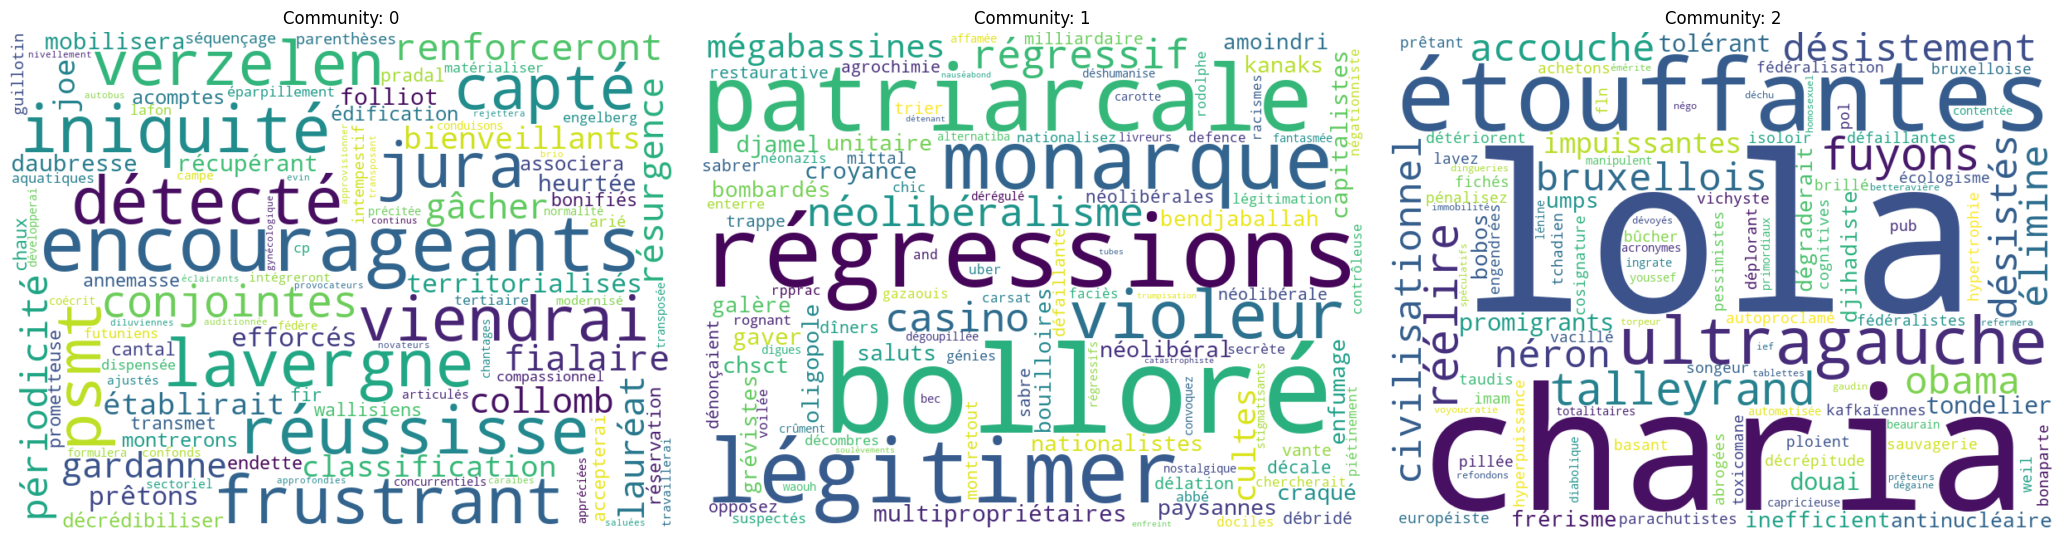

In [30]:
# --- STEP 6: Visualize the results using the provided plotting function ---
print("\nVisualizing Community DF-IDF scores...")
plot_community_wordclouds(community_df_idf_scores)